# The aim of this notebook is to create a model that predicts the size of a wildfire

Author: Marcelo Garcia Escalante

## Index

1. [EDA+Preprocess Data](#1.-EDA-(Exploratory-Data-Analysis)-+-preprocess-data)
 * [Clean data](#Clean-data)
     * [Parsing Dates](#Parsing-Dates)
     * [Find null values](#Find-null-values)
     * [fillining null data](#fillining-null-data)
 * [Feature engineering](#Feature-engineering)
 * [Standardize data](#Standardize-data)
 * [Visualize class distribution](#Visualize-class-distribution)
 
2. [Build Model](#2.-Build-Model)
 * [One Hot encode categorical data](#One-Hot-encode-categorical-data)
 * [Stratified cross validation](#Stratified-cross-validation)
 * [Define feature importance](#Define-feature-importance)
3. [Make submission](#3.-Make-submission)
4. [References](#4.-References)

In [190]:
# All imports for the project goes here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from helpers import feature_plot
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import category_encoders as ce
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from helpers import feature_plot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. EDA (Exploratory Data Analysis) + preprocess data

In this section, we will visualize and analyze our dataset. Also any possible clean-up required will be performed. 

In [2]:
# Loading the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.dtypes

fire_number                      object
fire_year                         int64
assessment_datetime              object
size_class                       object
fire_location_latitude          float64
fire_location_longitude         float64
fire_origin                      object
general_cause_desc               object
activity_class                   object
true_cause                       object
fire_start_date                  object
det_agent_type                   object
det_agent                        object
discovered_date                  object
reported_date                    object
start_for_fire_date              object
fire_fighting_start_date         object
initial_action_by                object
fire_type                        object
fire_position_on_slope           object
weather_conditions_over_fire     object
fuel_type                        object
bh_fs_date                       object
uc_fs_date                       object
ex_fs_date                       object


`note:` We can see that most of our data is categorical with two of the features being float numbers and one an integer

In [4]:
#Visualizing the train dataset
train.tail()

,fire_number,fire_year,assessment_datetime,size_class,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,activity_class,true_cause,...,start_for_fire_date,fire_fighting_start_date,initial_action_by,fire_type,fire_position_on_slope,weather_conditions_over_fire,fuel_type,bh_fs_date,uc_fs_date,ex_fs_date
15870,SWF001,2006,2006-04-07 17:55:00,B,55.355664,-115.776846,Indian Reservation,Incendiary,Lighting Fires,Arson Known,...,2006-04-07 18:00:00,NaN,Fire Department,Surface,Flat,Clear,O1a,2006-04-07 17:55:00,2006-04-07 17:55:00,2006-04-07 19:30:00
15871,HWF091,2008,2008-06-03 15:35:00,A,58.743900,-117.223467,Provincial Land,Lightning,NaN,NaN,...,2008-06-03 15:08:00,2008-06-03 16:00:00,HAC1F,Ground,Flat,Clear,C2,2008-06-03 16:42:00,2008-06-03 16:42:00,2008-06-03 18:24:00
15872,HWF234,2015,2015-06-26 15:27:00,E,59.846600,-116.768133,Provincial Land,Lightning,NaN,NaN,...,2015-06-26 17:30:00,2015-06-26 17:30:00,FTAC,Ground,Flat,CB Wet,C1,2015-06-26 22:00:00,2015-06-26 23:00:00,2015-07-01 10:46:00
15873,MWF097,2008,2008-07-19 14:59:00,A,56.300000,-112.535217,Provincial Land,Lightning,NaN,NaN,...,2008-07-19 14:55:00,2008-07-19 15:10:00,HAC1H,Surface,Flat,Cloudy,C2,2008-07-19 15:20:00,2008-07-19 15:30:00,2008-07-19 17:43:00
15874,SWF133,2015,2015-06-26 17:05:00,B,55.917023,-113.707167,Private Land,Resident,Debris Disposal,Unsafe Fire,...,2015-06-26 16:51:00,2015-06-26 17:25:00,HAC,Surface,Flat,Clear,M2,2015-06-26 17:52:00,2015-06-26 19:35:00,2015-06-27 16:40:00


In [5]:
#Visualizing the test dataset
test.tail()

,fire_number,fire_year,assessment_datetime,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,activity_class,true_cause,fire_start_date,...,start_for_fire_date,fire_fighting_start_date,initial_action_by,fire_type,fire_position_on_slope,weather_conditions_over_fire,fuel_type,bh_fs_date,uc_fs_date,ex_fs_date
3964,RWF047,2018,2018-07-30 17:21:00,52.490550,-115.964300,Provincial Land,Lightning,NaN,NaN,2018-07-30 16:30:00,...,2018-07-30 17:21:00,2018-07-30 17:42:00,HAC,Surface,Flat,Rainshowers,C3,2018-07-30 17:21:00,2018-07-30 17:50:00,2018-07-30 18:05:00
3965,GWF067,2009,2009-06-27 19:30:00,55.077350,-117.618717,Private Land,Resident,Refuse,Permit Related,2009-06-26 16:00:00,...,2009-06-27 19:00:00,NaN,Land Owner,Surface,Bottom,Cloudy,NaN,2009-06-27 19:30:00,2009-06-27 19:30:00,2009-06-30 14:30:00
3966,GWF194,2006,2006-09-07 14:35:00,54.350328,-119.919998,Provincial Land,Restart,NaN,NaN,2006-09-01 16:00:00,...,2006-09-07 14:51:00,2006-09-07 15:35:00,HAC1F,Ground,Upper 1/3,Clear,C3,2006-09-07 14:35:00,2006-09-07 14:35:00,2006-09-27 16:50:00
3967,LWF091,2012,2012-06-01 16:10:00,55.105667,-111.517000,Provincial Land,Recreation,Transportation,Vehicle Fire,2012-06-01 15:32:00,...,2012-06-01 15:38:00,NaN,Fire Department,Surface,Bottom,Clear,O1a,2012-06-01 16:10:00,2012-06-01 16:10:00,2012-06-01 16:24:00
3968,GWF084,2008,2008-07-09 09:26:00,55.035717,-117.867233,Private Land,Resident,Unclassified,Unpredictable Event,2008-07-08 21:00:00,...,2008-07-09 08:28:00,NaN,Fire Department,Surface,Flat,Clear,NaN,2008-07-09 09:26:00,2008-07-09 09:26:00,2008-07-15 10:40:00


In [6]:
# Shape of dataset
print(f"The shape of train dataset is: {train.shape}")
print(f"The shape of test dataset is: {test.shape}")

The shape of train dataset is: (15875, 25)
The shape of test dataset is: (3969, 24)


`comment:` First thing we can notice is that the features are not the same. Train has 25 features while test has only 24. let's see what is the difference

In [7]:
train.columns[np.array([feature not in test.columns for feature in train.columns])][0]

'size_class'

That will mean that our testing dataset does not have labels. The reason for this is that this is a contest and the labels are not provided as this will be the metric to assess the performance of all the models proposed by each contestant. 

`size_class` is the target we want to predict with our model. Let's visualize what are the possible outcomes of this feature:


In [8]:
classes = list(train['size_class'].unique())
print(f"The possible classes in the target feature are: {classes}")

The possible classes in the target feature are: ['A', 'B', 'D', 'E', 'C']


That will mean that we have 5 classes to predict. In fact in the dataset information we can find that these classes represent ranges to which the wildfire grows until the final aree burned is determined after extinghishment. The area is catalogized as follows: 

* **A:** 0 to 0.1 [ha]
* **B:** 0.1 to 4 [ha]
* **C:** 4 to 40 [ha]
* **D:** 40 to 200 [ha]
* **E:** more than 200 [ha]

`note:` all sizes are in hectare(ha). $$ 1 ha = 10000 m^2 $$

### Clean data

In this section we will clean all unnecesary data or parse any data that it is required

#### Parsing Dates
 
 As shown from all information above, we can tell that columns that contain dates are presented in our dataset as strings. Therefore we will need to parse them back to dates. The features that should contain dates are:
 
 * `assessment_datetime` - The date and time the wildfire was originally assessed by Wildfire Management employees 
 * `fire_start_date` - The time and date the wildfire started.
 * `discovered_date` - The time the detection agent first discovered the wildfire.
 * `reported_date` - The time and date the wildfire was first reported to Wildfire Management
 * `start_for_fire_date` - The time and date that the first Wildfire Management resource started for the wildfire.
 * `fire_fighting_start_date` - The time and date that the initial action resource began physical suppression on the wildfire.
 * `bh_fs_date` - The date and time the Incident Commander (IC) determined the wildfire to be at the fire status of
being held (BH).
 * `uc_fs_date` - The date and time the Incident Commander determined the wildfire to be at the fire status of under
control (UC).
 * `ex_fs_date` - This is the date and time the Incident Commander determined the wildfire to be completely
extinguished (EX).


In [9]:
dates_list = ['assessment_datetime', 'fire_start_date', 'discovered_date', 'reported_date', 'start_for_fire_date', 
             'fire_fighting_start_date', 'bh_fs_date', 'uc_fs_date', 'ex_fs_date']
display(train[dates_list].sample(1))
train[dates_list].dtypes

,assessment_datetime,fire_start_date,discovered_date,reported_date,start_for_fire_date,fire_fighting_start_date,bh_fs_date,uc_fs_date,ex_fs_date
1371,2012-07-17 18:57:00,2012-07-17 18:30:00,2012-07-17 18:50:00,2012-07-17 18:50:00,2012-07-17 18:55:00,2012-07-17 19:00:00,2012-07-17 19:05:00,2012-07-17 19:15:00,2012-07-17 19:54:00


assessment_datetime         object
fire_start_date             object
discovered_date             object
reported_date               object
start_for_fire_date         object
fire_fighting_start_date    object
bh_fs_date                  object
uc_fs_date                  object
ex_fs_date                  object
dtype: object

- We can see that all the dates have the format = `%y-%m-%d %H:%M:%S`
- We can also see that all of them have type object. Therefore we need to convert this values into datetime format

In [10]:
# parsing the object to datetime type
train[dates_list]=pd.to_datetime(train[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()
test[dates_list]=pd.to_datetime(test[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()

In [11]:
train[dates_list].dtypes

assessment_datetime         datetime64[ns]
fire_start_date             datetime64[ns]
discovered_date             datetime64[ns]
reported_date               datetime64[ns]
start_for_fire_date         datetime64[ns]
fire_fighting_start_date    datetime64[ns]
bh_fs_date                  datetime64[ns]
uc_fs_date                  datetime64[ns]
ex_fs_date                  datetime64[ns]
dtype: object

We can see that date features are now of type `datetime64`.

#### Find null values
we will look for empty or null values that could make invalid our analysis

In [12]:
null_counts = train.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

true_cause                      7194
activity_class                  6197
fuel_type                       4793
fire_fighting_start_date        4199
discovered_date                 2119
weather_conditions_over_fire    1893
fire_position_on_slope          1888
fire_type                       1819
fire_start_date                  433
fire_origin                        7
reported_date                      1
det_agent                          1
det_agent_type                     1
dtype: int64

In [13]:
null_counts = test.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

true_cause                      1796
activity_class                  1524
fuel_type                       1247
fire_fighting_start_date        1080
discovered_date                  546
weather_conditions_over_fire     456
fire_position_on_slope           456
fire_type                        434
fire_start_date                  112
fire_origin                        3
dtype: int64

`comment:` From above we can see that most of the missing data for both datasets are in the `true_cause` and `activity class` features, which means that we don't know what was the true reason of the wildfire or what was the activity that was going on when the wildfire was started. 

In [14]:
pd.set_option('display.max_columns', None)
print(f"Number of datapoints that have at least one value missing: {len(train[train.isnull().any(axis=1)])}")

Number of datapoints that have at least one value missing: 14137


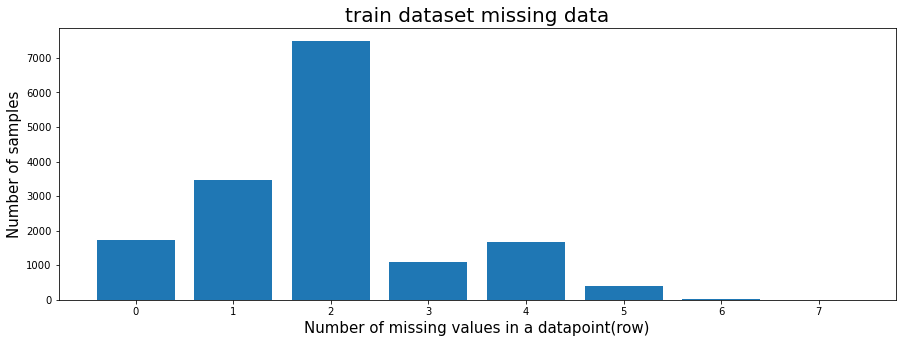

In [15]:
plt.figure(figsize=(15,5))
plt.bar(*zip(*dict(Counter(train.isnull().sum(axis=1))).items()))
plt.xlabel('Number of missing values in a datapoint(row)', fontsize=15)
plt.ylabel('Number of samples', fontsize=15)
plt.title('train dataset missing data', fontsize=20)
plt.show()

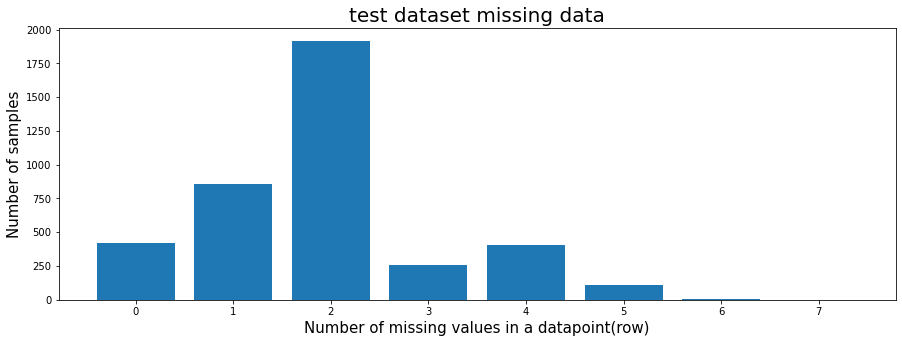

In [16]:
plt.figure(figsize=(15,5))
plt.bar(*zip(*dict(Counter(test.isnull().sum(axis=1))).items()))
plt.xlabel('Number of missing values in a datapoint(row)', fontsize=15)
plt.ylabel('Number of samples', fontsize=15)
plt.title('test dataset missing data', fontsize=20)
plt.show()

`comment:` We can see from above that in most of our data 2 missing features are common followed by one missing feature per row. Most likely `true_cause` and `activity class` as they are the most frequent missing feature. That means that perhaps it is not a good idea to trust in this features for building our model.

#### fillining null data
Since all of the features that contain null values are categorical, we will proceed to change the `NaN` to `unknown`

In [17]:
# Mean Year
train[dates_list].stack().dt.year.unstack().mean(axis=0)

assessment_datetime         2011.717228
fire_start_date             2011.673358
discovered_date             2011.523481
reported_date               2011.717400
start_for_fire_date         2011.717291
fire_fighting_start_date    2011.864937
bh_fs_date                  2011.717228
uc_fs_date                  2011.717228
ex_fs_date                  2011.720630
dtype: float64

In [18]:
# Mean Month
train[dates_list].stack().dt.month.unstack().mean(axis=0)

assessment_datetime         6.286677
fire_start_date             6.275029
discovered_date             6.320151
reported_date               6.285687
start_for_fire_date         6.286173
fire_fighting_start_date    6.402792
bh_fs_date                  6.291339
uc_fs_date                  6.307339
ex_fs_date                  6.353512
dtype: float64

In [19]:
# Mean Day
train[dates_list].stack().dt.day.unstack().mean(axis=0)

assessment_datetime         15.556157
fire_start_date             15.464189
discovered_date             15.571896
reported_date               15.552413
start_for_fire_date         15.549669
fire_fighting_start_date    15.657674
bh_fs_date                  15.539780
uc_fs_date                  15.543937
ex_fs_date                  15.626898
dtype: float64

In [20]:
# First fill NAN datetime types with mean of year, month and day
train[dates_list] = train[dates_list].fillna(datetime(2011,6, 16))
test[dates_list] = test[dates_list].fillna(datetime(2011,6, 16))

In [21]:
# Fill remaining object types
train = train.fillna('Unknown')
test = test.fillna('Unknown')

### Feature engineering

As we saw above we have many datetimes in out dataset. However, this will only be usable if we feed them to our model. To achieve this we will need to convert our datetime features to countable features. In this regard I will create new features for year month and day for all each datetime feature.

In [22]:
def datetime_feature_engineering(df, inplace = False):
    """
        This function generates year, month and day for each datetime feature
    """
    date_indx = np.where(df.dtypes=='<M8[ns]')[0]
    df_temp = df.copy(deep=True)
    for i in date_indx:
        curr_column = df_temp.columns[i]
        df_temp[curr_column+"_Year"] = df_temp[curr_column].dt.year
        df_temp[curr_column+"_Month"] = df_temp[curr_column].dt.month
        df_temp[curr_column+"_Day"] = df_temp[curr_column].dt.day
    
    return df_temp.drop(list(df_temp.columns[date_indx]), 1, inplace=inplace)

In [23]:
train_feng = datetime_feature_engineering(train)
test_feng = datetime_feature_engineering(test)

In [24]:
train_feng.dtypes

fire_number                        object
fire_year                           int64
size_class                         object
fire_location_latitude            float64
fire_location_longitude           float64
fire_origin                        object
general_cause_desc                 object
activity_class                     object
true_cause                         object
det_agent_type                     object
det_agent                          object
initial_action_by                  object
fire_type                          object
fire_position_on_slope             object
weather_conditions_over_fire       object
fuel_type                          object
assessment_datetime_Year            int64
assessment_datetime_Month           int64
assessment_datetime_Day             int64
fire_start_date_Year                int64
fire_start_date_Month               int64
fire_start_date_Day                 int64
discovered_date_Year                int64
discovered_date_Month             

### Standardize data

It is important to standardize data as we don't want our model to skew towards features that have higher values

In [25]:
# lest visualize non-standard data first
train_feng.describe()

,fire_year,fire_location_latitude,fire_location_longitude,assessment_datetime_Year,assessment_datetime_Month,assessment_datetime_Day,fire_start_date_Year,fire_start_date_Month,fire_start_date_Day,discovered_date_Year,discovered_date_Month,discovered_date_Day,reported_date_Year,reported_date_Month,reported_date_Day,start_for_fire_date_Year,start_for_fire_date_Month,start_for_fire_date_Day,fire_fighting_start_date_Year,fire_fighting_start_date_Month,fire_fighting_start_date_Day,bh_fs_date_Year,bh_fs_date_Month,bh_fs_date_Day,uc_fs_date_Year,uc_fs_date_Month,uc_fs_date_Day,ex_fs_date_Year,ex_fs_date_Month,ex_fs_date_Day
count,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000
mean,2011.717228,54.984684,-115.258572,2011.717228,6.286677,15.556157,2011.654992,6.267528,15.478803,2011.453606,6.277417,15.629039,2011.717354,6.285669,15.552441,2011.717291,6.286173,15.549669,2011.636157,6.296252,15.748220,2011.717228,6.291339,15.539780,2011.717228,6.307339,15.543937,2011.720630,6.353512,15.626898
std,3.737510,2.669900,2.300677,3.737510,1.715796,8.892923,3.809908,1.800088,8.827900,3.440842,1.512500,8.310507,3.737351,1.715119,8.899744,3.737591,1.715439,8.894244,3.473912,1.338692,7.717411,3.737510,1.716148,8.895264,3.737510,1.722852,8.907601,3.739771,1.750719,8.931589
min,2006.000000,49.056267,-119.998067,2006.000000,1.000000,1.000000,1900.000000,1.000000,1.000000,2006.000000,1.000000,1.000000,2006.000000,1.000000,1.000000,2006.000000,1.000000,1.000000,2006.000000,1.000000,1.000000,2006.000000,1.000000,1.000000,2006.000000,1.000000,1.000000,2006.000000,1.000000,1.000000
25%,2008.000000,53.066609,-116.824059,2008.000000,5.000000,8.000000,2008.000000,5.000000,8.000000,2009.000000,5.000000,9.000000,2008.000000,5.000000,8.000000,2008.000000,5.000000,8.000000,2010.000000,6.000000,11.000000,2008.000000,5.000000,7.000000,2008.000000,5.000000,7.000000,2008.000000,5.000000,7.000000
50%,2012.000000,55.336950,-115.156817,2012.000000,6.000000,16.000000,2011.000000,6.000000,16.000000,2011.000000,6.000000,16.000000,2012.000000,6.000000,16.000000,2012.000000,6.000000,16.000000,2011.000000,6.000000,16.000000,2012.000000,6.000000,16.000000,2012.000000,6.000000,16.000000,2012.000000,6.000000,16.000000
75%,2015.000000,56.876556,-114.340384,2015.000000,7.000000,23.000000,2015.000000,7.000000,23.000000,2014.000000,7.000000,22.000000,2015.000000,7.000000,23.000000,2015.000000,7.000000,23.000000,2014.000000,7.000000,21.000000,2015.000000,7.000000,23.000000,2015.000000,7.000000,23.000000,2015.000000,7.000000,23.000000
max,2018.000000,59.999510,-110.000917,2018.000000,12.000000,31.000000,2018.000000,12.000000,31.000000,2018.000000,12.000000,31.000000,2018.000000,12.000000,31.000000,2018.000000,12.000000,31.000000,2090.000000,12.000000,31.000000,2018.000000,12.000000,31.000000,2018.000000,12.000000,31.000000,2019.000000,12.000000,31.000000


In [26]:
# training standarized
numeric_features_indx = np.where(train_feng.dtypes!='O')[0]
numeric_features = train_feng.columns[numeric_features_indx]
standardize = StandardScaler()
train_feng[numeric_features] = standardize.fit_transform(train_feng[numeric_features])
# testing standarized
numeric_features_indx = np.where(test_feng.dtypes!='O')[0]
numeric_features = test_feng.columns[numeric_features_indx]
standardize = StandardScaler()
test_feng[numeric_features] = standardize.fit_transform(test_feng[numeric_features])


In [27]:
train_feng.describe()

,fire_year,fire_location_latitude,fire_location_longitude,assessment_datetime_Year,assessment_datetime_Month,assessment_datetime_Day,fire_start_date_Year,fire_start_date_Month,fire_start_date_Day,discovered_date_Year,discovered_date_Month,discovered_date_Day,reported_date_Year,reported_date_Month,reported_date_Day,start_for_fire_date_Year,start_for_fire_date_Month,start_for_fire_date_Day,fire_fighting_start_date_Year,fire_fighting_start_date_Month,fire_fighting_start_date_Day,bh_fs_date_Year,bh_fs_date_Month,bh_fs_date_Day,uc_fs_date_Year,uc_fs_date_Month,uc_fs_date_Day,ex_fs_date_Year,ex_fs_date_Month,ex_fs_date_Day
count,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04,1.587500e+04
mean,-1.524702e-14,1.673076e-15,1.669496e-15,-1.524702e-14,2.466199e-16,6.624272e-17,-2.203846e-14,3.591877e-17,-8.146065e-17,-1.546208e-14,-1.485985e-16,4.744411e-17,-2.595864e-14,-1.728801e-16,8.011789e-17,-2.058582e-14,-2.033159e-16,-5.997652e-17,-4.974247e-15,-2.639638e-16,-1.342758e-17,-1.524702e-14,-2.384514e-16,-2.193171e-17,-1.524702e-14,-2.240168e-16,-1.700827e-17,3.110723e-17,2.027564e-16,-2.439344e-17
std,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00
min,-1.529737e+00,-2.220534e+00,-2.060109e+00,-1.529737e+00,-3.081278e+00,-1.636876e+00,-2.930741e+01,-2.926353e+00,-1.640170e+00,-1.585012e+00,-3.489311e+00,-1.760362e+00,-1.529836e+00,-3.081906e+00,-1.635204e+00,-1.529721e+00,-3.081625e+00,-1.635904e+00,-1.622475e+00,-3.956414e+00,-1.911092e+00,-1.529737e+00,-3.083361e+00,-1.634604e+00,-1.529737e+00,-3.080651e+00,-1.632807e+00,-1.529722e+00,-3.057989e+00,-1.637711e+00
25%,-9.946047e-01,-7.184300e-01,-6.804676e-01,-9.946047e-01,-7.499248e-01,-8.497089e-01,-9.593690e-01,-7.041696e-01,-8.472048e-01,-7.131055e-01,-8.446001e-01,-7.976948e-01,-9.946808e-01,-7.496330e-01,-8.486400e-01,-9.946001e-01,-7.497869e-01,-8.488532e-01,-4.709990e-01,-2.213066e-01,-6.152802e-01,-9.946047e-01,-7.524869e-01,-9.600669e-01,-9.946047e-01,-7.588463e-01,-9.592040e-01,-9.949130e-01,-7.731419e-01,-9.659165e-01
50%,7.566014e-02,1.319439e-01,4.422967e-02,7.566014e-02,-1.670865e-01,4.991120e-02,-1.719235e-01,-1.486238e-01,5.904159e-02,-1.318342e-01,-1.834222e-01,4.463895e-02,7.562965e-02,-1.665647e-01,5.029057e-02,7.564166e-02,-1.668274e-01,5.063330e-02,-1.831300e-01,-2.213066e-01,3.262590e-02,7.566014e-02,-1.697684e-01,5.173933e-02,7.566014e-02,-1.783951e-01,5.120092e-02,7.470481e-02,-2.019301e-01,4.177466e-02
75%,8.783588e-01,7.086151e-01,3.991075e-01,8.783588e-01,4.157519e-01,8.370788e-01,8.780038e-01,4.069220e-01,8.520072e-01,7.400728e-01,4.777557e-01,7.666393e-01,8.783625e-01,4.165036e-01,8.368549e-01,8.783230e-01,4.161321e-01,8.376840e-01,6.804770e-01,5.257149e-01,6.805319e-01,8.783588e-01,4.129501e-01,8.386997e-01,8.783588e-01,4.020562e-01,8.370714e-01,8.769182e-01,3.692817e-01,8.255345e-01
max,1.681057e+00,1.878342e+00,2.285337e+00,1.681057e+00,3.329944e+00,1.736699e+00,1.665449e+00,3.184651e+00,1.758254e+00,1.902615e+00,3.783645e+00,1.849640e+00,1.681095e+00,3.331845e+00,1.735785e+00,1.681004e+00,3.330930e+00,1.737170e+00,2.255852e+01,4.260822e+00,1.976344e+00,1.681057e+00,3.326543e+00,1.738083e+00,1.681057e+00,3.304313e+00,1.735209e+00,1.946536e+00,3.225341e+00,1.721260e+00


In [28]:
test_feng.describe()

,fire_year,fire_location_latitude,fire_location_longitude,assessment_datetime_Year,assessment_datetime_Month,assessment_datetime_Day,fire_start_date_Year,fire_start_date_Month,fire_start_date_Day,discovered_date_Year,discovered_date_Month,discovered_date_Day,reported_date_Year,reported_date_Month,reported_date_Day,start_for_fire_date_Year,start_for_fire_date_Month,start_for_fire_date_Day,fire_fighting_start_date_Year,fire_fighting_start_date_Month,fire_fighting_start_date_Day,bh_fs_date_Year,bh_fs_date_Month,bh_fs_date_Day,uc_fs_date_Year,uc_fs_date_Month,uc_fs_date_Day,ex_fs_date_Year,ex_fs_date_Month,ex_fs_date_Day
count,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03,3.969000e+03
mean,-1.899435e-14,-1.134111e-15,-3.191982e-15,-1.899435e-14,1.745475e-16,5.616850e-17,-2.960684e-14,-6.131542e-17,-6.981901e-17,-2.387810e-14,-2.403385e-16,4.072776e-17,-1.899435e-14,-9.309202e-17,6.802878e-17,-1.899435e-14,2.260167e-16,3.580462e-18,2.231165e-14,-6.668611e-17,-8.951156e-18,-1.899435e-14,4.923136e-18,-2.439190e-17,-1.899435e-14,-1.969254e-17,-2.014010e-17,1.292547e-15,-8.414086e-17,8.593109e-17
std,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00
min,-1.518005e+00,-2.117637e+00,-2.085803e+00,-1.518005e+00,-3.082682e+00,-1.619771e+00,-1.785806e+00,-2.906866e+00,-1.615941e+00,-1.569820e+00,-3.535101e+00,-1.744671e+00,-1.518005e+00,-3.080476e+00,-1.619198e+00,-1.518005e+00,-3.081976e+00,-1.618098e+00,-1.282260e+00,-3.945440e+00,-1.888926e+00,-1.518005e+00,-3.082698e+00,-1.614449e+00,-1.518005e+00,-3.080211e+00,-1.624441e+00,-1.518141e+00,-3.059699e+00,-1.643016e+00
25%,-9.841613e-01,-7.431657e-01,-6.754829e-01,-9.841613e-01,-7.463892e-01,-9.486168e-01,-9.774889e-01,-6.929345e-01,-9.391676e-01,-7.001891e-01,-8.524729e-01,-7.859671e-01,-9.841613e-01,-7.450749e-01,-9.475923e-01,-9.841613e-01,-7.466643e-01,-9.470300e-01,-3.752398e-01,-2.177092e-01,-5.864788e-01,-9.841613e-01,-7.487329e-01,-9.427304e-01,-9.841613e-01,-7.531228e-01,-9.509656e-01,-9.843199e-01,-7.718420e-01,-9.730943e-01
50%,8.352660e-02,1.218465e-01,3.408995e-02,8.352660e-02,-1.623161e-01,5.811367e-02,-1.691716e-01,-1.394515e-01,7.599280e-02,-1.204351e-01,-1.818158e-01,5.289902e-02,8.352660e-02,-1.612245e-01,5.981676e-02,8.352660e-02,-1.628364e-01,5.957156e-02,-1.484848e-01,-2.177092e-01,6.474500e-02,8.352660e-02,-1.652417e-01,6.484762e-02,8.352660e-02,-1.713508e-01,5.924799e-02,8.332120e-02,-1.998777e-01,3.178852e-02
75%,8.842925e-01,7.251682e-01,3.754646e-01,8.842925e-01,4.217570e-01,8.411263e-01,9.085848e-01,4.140315e-01,7.527664e-01,7.491957e-01,4.888413e-01,7.719271e-01,8.842925e-01,4.226259e-01,8.433572e-01,8.842925e-01,4.209916e-01,8.424839e-01,5.317802e-01,5.278369e-01,5.857240e-01,8.842925e-01,4.182496e-01,8.485194e-01,8.842925e-01,4.104212e-01,8.449696e-01,8.840521e-01,3.720867e-01,8.133641e-01
max,1.685058e+00,1.867375e+00,2.276578e+00,1.685058e+00,3.342123e+00,1.735998e+00,1.716902e+00,3.181446e+00,1.767927e+00,1.908704e+00,3.842127e+00,1.850469e+00,1.685058e+00,3.341878e+00,1.738832e+00,1.685058e+00,3.340131e+00,1.737241e+00,3.363801e+01,4.255567e+00,2.018416e+00,1.685058e+00,3.335706e+00,1.744144e+00,1.685058e+00,3.319281e+00,1.742937e+00,1.684783e+00,3.231908e+00,1.706593e+00



### Visualize class distribution
Lets visualize data distribution grouped by class of the target feature after the clean up

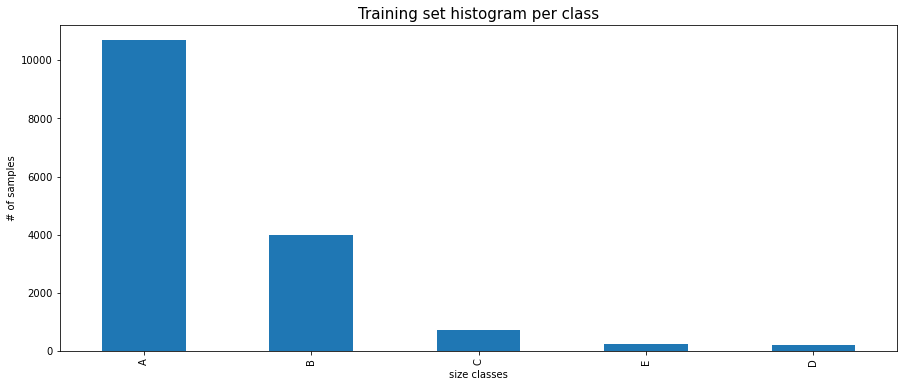

In [29]:
plt.figure(figsize=(15,6))
train_feng['size_class'].value_counts().plot(kind='bar');
plt.title('Training set histogram per class', fontsize=15);
plt.xlabel('size classes')
plt.ylabel('# of samples');

In [30]:
train_feng['size_class'].value_counts()

A    10679
B     4000
C      734
E      246
D      216
Name: size_class, dtype: int64

From plot above, we can notice that we have an unbalanced number of classes. Therefore, we must be very cautious to not make our model skew towards the classes with more data

## 2. Build Model

In this section we will build a model to classify `size_class` of our dataset.


### One Hot encode categorical data

In [35]:
# Extract y_train and X_train
y_train = train_feng[['size_class']]
X_train = train_feng.drop(['size_class', 'fire_number'], 1)
# Extract and X_test
X_test = test_feng.drop(['fire_number'], 1)

In [47]:
# One hot encode data
X_train_ohe = pd.get_dummies(X_train)
X_test_ohe = pd.get_dummies(X_test)

### Stratified cross validation

We are going to use stratified cross validation to mitigate the imbalance of the dataset that we saw in the EDA section [class distribution](#Visualize-class-distribution) 

In [106]:
train_X, validation_X, train_y, validation_y = train_test_split(X_train_ohe, y_train, 
                                                                test_size=0.25, random_state=2, 
                                                                stratify=y_train)

### Define feature importance

In all datasets there is always a high chance that some features are irrelevant to predict the target feature. We could try guessing which ones are the most relevant using our intuition. However, intuition is not always good. Therefore, there is an alternative way to do it using feature importances that is available for tree based models in Sklearn. To quickly identify some of the features let's use a simple random forest classifier.

In [121]:
model = AdaBoostClassifier(random_state=42)
model.fit(train_X.values, train_y.values.ravel())

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_


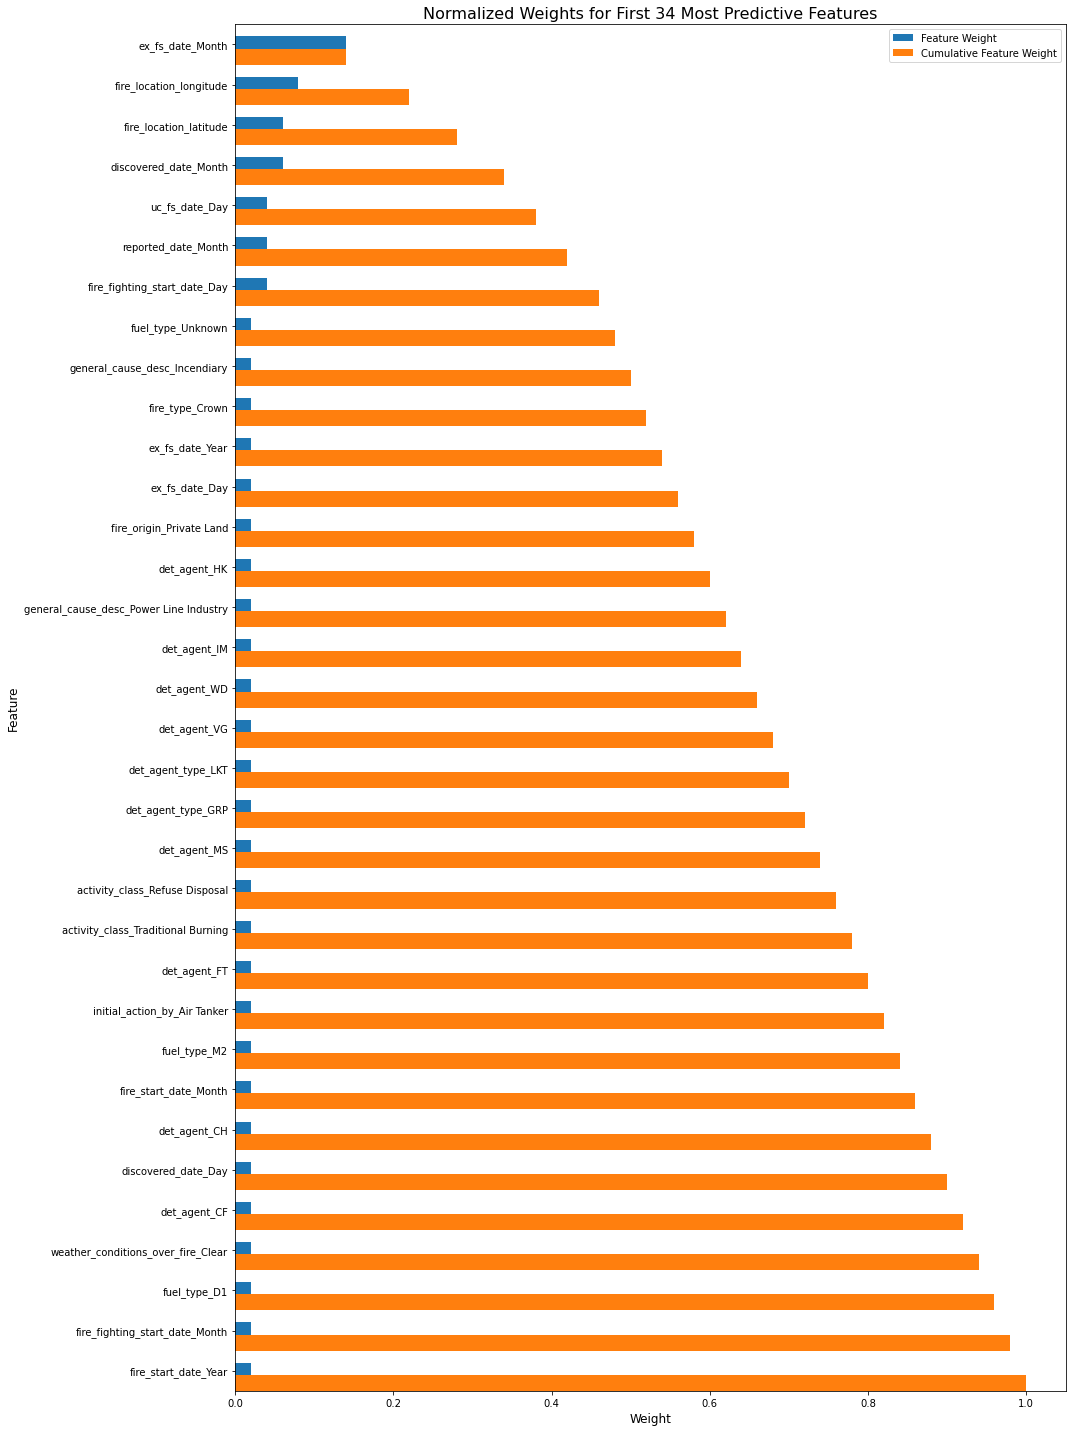

,Features,Importance value
0,ex_fs_date_Month,0.14
1,fire_location_longitude,0.08
2,fire_location_latitude,0.06
3,discovered_date_Month,0.06
4,uc_fs_date_Day,0.04
5,reported_date_Month,0.04
6,fire_fighting_start_date_Day,0.04
7,fuel_type_Unknown,0.02
8,general_cause_desc_Incendiary,0.02
9,fire_type_Crown,0.02


In [126]:
relevant_df = feature_plot(importances, train_X, train_y, top_k=34)
relevant_df

We are going to test the model by using only the first 7 features that are the most relevant

In [176]:
most_relevant_features = relevant_df[
    (relevant_df['Importance value']>0.01)&(relevant_df['Features']!='fuel_type_Unknown')]['Features']
most_relevant_features

0                       ex_fs_date_Month
1                fire_location_longitude
2                 fire_location_latitude
3                  discovered_date_Month
4                         uc_fs_date_Day
                     ...                
29                          det_agent_CF
30    weather_conditions_over_fire_Clear
31                          fuel_type_D1
32        fire_fighting_start_date_Month
33                  fire_start_date_Year
Name: Features, Length: 33, dtype: object

## Train Validation results

In [177]:
model = AdaBoostClassifier(random_state=42)
model.fit(train_X[most_relevant_features].values, train_y.values.ravel())

AdaBoostClassifier(random_state=42)

In [178]:
# prediction train dataset
pred_train_y = model.predict(train_X[most_relevant_features])
# prediction validation dataset
pred_validation_y = model.predict(validation_X[most_relevant_features])

In [179]:
train_f1_score = fbeta_score(train_y.values.ravel(), pred_train_y, beta = 1, average='macro')
validation_f1_score = fbeta_score(validation_y.values.ravel(), pred_validation_y, beta = 1, average='macro')
print(f"F1-score - train:{train_f1_score} - validation: {validation_f1_score}")

F1-score - train:0.33441399813281103 - validation: 0.31032931835821964


#### Optimize model

In [206]:
# Initialize the classifier
model = AdaBoostClassifier(random_state=42)

# Create the parameters to tune
parameters = {  
    'n_estimators': [700],
    'learning_rate': [0.5, 0.6, 0.7, 0.8],
}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=1.0, average='macro')

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(model, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(train_X[most_relevant_features].values, train_y.values.ravel())

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the optimized model
best_predictions_validation = best_clf.predict(validation_X[most_relevant_features])
best_predictions_train = best_clf.predict(train_X[most_relevant_features])

# Report the before-and-afterscores
print("Optimized model\n------")
print("F-score on validation data: {:.4f}".format(fbeta_score(validation_y.values.ravel(), 
                                                              best_predictions_validation, 
                                                              beta = 1.0, average='macro')))

print("F-score on training data: {:.4f}".format(fbeta_score(train_y.values.ravel(), 
                                                            best_predictions_train, 
                                                            beta = 1.0, average='macro')))

KeyboardInterrupt: 

In [200]:
best_clf

AdaBoostClassifier(learning_rate=0.5, n_estimators=700, random_state=42)

## 3. Make submission

In [201]:
y_test_pred = pd.DataFrame()
y_test_pred['fire_number'] = test_feng['fire_number']
y_test_pred['size_class'] = best_clf.predict(X_test_ohe[most_relevant_features])

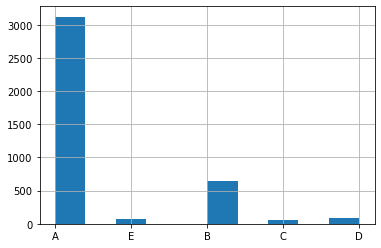

In [202]:
y_test_pred['size_class'].hist()

In [203]:
print(y_test_pred.shape)

(3969, 2)


### Push the prediction to CARINO platform

In [204]:
import math
import requests

TOKEN = 'bef13dde60939ab809582f85a2518337f4eee028e2ea385cf64831961737072d977ed884b5c4e58821b1e5f1f5376aa2f6afecacab61ea9ecf406c89cc1e19cf' # Replace with 'your token' (please ensure value is between quotes)
comment = 'some comment' # Free text, visible by you only

def submit_prediction(df, TOKEN=None, sep=',', comment='', compression='gzip', **kwargs):
    if TOKEN is None:
        print("Please set TOKEN to the value provided in CARINO plarform under Submissions tab")
        return None
    URL='http://18.185.86.47/api/submissions'
    df.to_csv('temporary.dat', sep=sep, compression=compression, **kwargs)
    r = requests.post(URL, headers={'Authorization': 'Bearer {}'.format(TOKEN)},files={'datafile': open('temporary.dat', 'rb')},data={'comment':comment, 'compression': compression})
    if r.status_code == 429:
        raise Exception('Submissions are too close. Next submission is only allowed in {} minutes.'.format(int(math.ceil(int(r.headers['x-rate-limit-remaining']) / 1000.0 / 60.0))))
    if r.status_code != 200:
        raise Exception(r.text)

In [205]:
submit_prediction(y_test_pred, TOKEN, sep=',', index=True, comment=comment)

## 4. References

* [Stratified cross validation](https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/)
* [Oversampling using SMOTE](https://medium.com/lumiata/cross-validation-for-imbalanced-datasets-9d203ba47e8)

In [ ]:
### Place holder
ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
X_train_ohe = ohe.fit_transform(X_train)
X_train_ohe.info(verbose=True)